In [936]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [652]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [653]:
import json
raw_recipe_data = pd.read_json(datafile)

## Preliminary data cleaning

In [654]:
raw_recipe_data.isnull().values.any()

False

In [655]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [656]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [657]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [658]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])

raw_recipe_data.Author.value_counts()

exception                    118
LoveMexiFood                  13
TheBritishBaker               13
witchywoman                   11
Johanna WISHES she were a     11
Litegal1                      10
Semigourmet                   10
Chef John                     10
Peach822                      10
ellie                         10
bellepepper                   10
Name: Author, dtype: int64

In [659]:
raw_recipe_data.drop(3, axis=0, inplace=True)
raw_recipe_data = raw_recipe_data[raw_recipe_data.Author != "exception"]
raw_recipe_data.reset_index(inplace=True)
raw_recipe_data.head(1)

,index,Author,Instructions
0,0,witchywoman,"Mix grapefruit, orange, apples, pineapple, mar..."


In [660]:
raw_recipe_data.drop(['index'], axis=1, inplace=True)
raw_recipe_data.head(1)

,Author,Instructions
0,witchywoman,"Mix grapefruit, orange, apples, pineapple, mar..."


In [661]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [662]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
3,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
4,witchywoman,[fill a pint glass with ice and pour in the vo...


In [663]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [664]:
raw_recipe_data.loc[:,"FullInstruction"] = raw_recipe_data.Instructions.apply(lambda x: "".join(x))


In [665]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [666]:
# get instructions
sentences = [text for text in raw_recipe_data.FullInstruction]
sentences[0]

'mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl mash slightly with the back of a wooden spoon to release juices add bananas coconut walnuts and sugar stir to coat cover and refrigerate to blend flavors at least 1 hour'

In [667]:
# remove stop words
stoplist = set('a an and are as at be by for from has he in is it its of on or that the to was will with'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in sentences]

In [668]:
# flatten list of words of sentences
raw_recipe_data.dtypes

Author             object
Instructions       object
FullInstruction    object
dtype: object

In [669]:
raw_recipe_data['Author'] = raw_recipe_data['Author'].astype('category')
raw_recipe_data.dtypes

Author             category
Instructions         object
FullInstruction      object
dtype: object

In [670]:
raw_recipe_data['Author_codes'] = raw_recipe_data['Author'].cat.codes
raw_recipe_data.head()

,Author,Instructions,FullInstruction,Author_codes
0,witchywoman,[mix grapefruit orange apples pineapple marasc...,mix grapefruit orange apples pineapple marasch...,9
1,witchywoman,"[fill a margarita glass with crushed ice, pou...",fill a margarita glass with crushed ice pour t...,9
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...,preheat an oven to 350 degrees f 175 degrees c...,9
3,witchywoman,[mix the teriyaki sauce garlic ginger and red ...,mix the teriyaki sauce garlic ginger and red p...,9
4,witchywoman,[fill a pint glass with ice and pour in the vo...,fill a pint glass with ice and pour in the vod...,9


In [671]:
raw_recipe_data['Author_codes'].value_counts()

6    13
3    13
1    11
9    10
8    10
7    10
5    10
4    10
2    10
0    10
Name: Author_codes, dtype: int64

### Reserve 25% of corpus for testing

In [672]:
len(sentences_text)

107

In [673]:
np.random.shuffle(sentences_text)
train, test = sentences_text[:81], sentences_text[81:]

## Create our gensim model

In [674]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [785]:
gensim.__version__

'3.4.0'

In [817]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-05-08 16:13:53,233 : INFO : collecting all words and their counts
2018-05-08 16:13:53,240 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-08 16:13:53,247 : INFO : collected 1051 word types from a corpus of 4611 raw words and 81 sentences
2018-05-08 16:13:53,250 : INFO : Loading a fresh vocabulary
2018-05-08 16:13:53,257 : INFO : min_count=3 retains 409 unique words (38% of original 1051, drops 642)
2018-05-08 16:13:53,258 : INFO : min_count=3 leaves 3803 word corpus (82% of original 4611, drops 808)
2018-05-08 16:13:53,263 : INFO : deleting the raw counts dictionary of 1051 items
2018-05-08 16:13:53,264 : INFO : sample=0.001 downsamples 106 most-common words
2018-05-08 16:13:53,266 : INFO : downsampling leaves estimated 2784 word corpus (73.2% of prior 3803)
2018-05-08 16:13:53,274 : INFO : estimated required memory for 409 words and 100 dimensions: 531700 bytes
2018-05-08 16:13:53,275 : INFO : resetting layer weights
2018-05-08 16:13:53,286 : IN

In [676]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [861]:
word_vectors = model.wv

### Vectorize our instructions.. for Science!

In [678]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word not in index2word_set:
            if model.__contains__(word):
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [679]:
raw_recipe_data['Instruction_Vectors'] = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(),
                                                                                                             word_vectors,
                                                                                                             num_features = 100,
                                                                                                             index2word_set = stoplist))


In [680]:
# make dataframe from vectors so I don't have to use list() with my X later
vector_df = pd.DataFrame(data=list(raw_recipe_data.Instruction_Vectors))

In [681]:
vector_df['Author'] = raw_recipe_data['Author']

In [714]:
vector_df.shape

(107, 101)

In [716]:
FI_X = vector_df.loc[:, vector_df.columns != 'Author']
FI_y = vector_df['Author']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.115130,-0.075797,0.048708,-0.125657,-0.130995,-0.082712,0.058929,-0.125005,0.302248,-0.228819,...,-0.078681,0.106107,0.096106,0.164451,-0.168183,0.048441,0.028068,0.127150,0.090639,-0.062593
1,0.116507,-0.075797,0.047739,-0.125262,-0.131313,-0.083225,0.059114,-0.124024,0.301785,-0.230273,...,-0.078971,0.105640,0.094358,0.163131,-0.166961,0.049610,0.027324,0.126631,0.090023,-0.061409
2,0.131395,-0.086026,0.054087,-0.143467,-0.149473,-0.094825,0.066492,-0.141630,0.345529,-0.261441,...,-0.091343,0.121130,0.109409,0.187724,-0.191681,0.055900,0.032611,0.143677,0.102605,-0.069871
3,0.124250,-0.081981,0.050960,-0.135594,-0.141197,-0.089906,0.062406,-0.133225,0.326451,-0.247907,...,-0.086289,0.115093,0.104384,0.176498,-0.181283,0.052081,0.030906,0.135370,0.096532,-0.066297
4,0.112650,-0.073840,0.046603,-0.121839,-0.127110,-0.079713,0.058008,-0.120659,0.293459,-0.223435,...,-0.076537,0.101929,0.092369,0.159477,-0.161713,0.048697,0.026707,0.123227,0.087257,-0.060847
5,0.133997,-0.085750,0.054583,-0.144087,-0.150243,-0.096725,0.067729,-0.143655,0.347818,-0.263399,...,-0.090983,0.121789,0.111380,0.187844,-0.193873,0.056360,0.033924,0.145197,0.104063,-0.070880
6,0.123810,-0.079968,0.051164,-0.134136,-0.140900,-0.088564,0.063324,-0.133537,0.324090,-0.245633,...,-0.084311,0.113365,0.103817,0.175326,-0.179563,0.053611,0.030704,0.135872,0.096642,-0.067794
7,0.113620,-0.074963,0.046013,-0.122797,-0.128363,-0.083325,0.057335,-0.121209,0.296931,-0.225208,...,-0.078226,0.104184,0.095929,0.160633,-0.164564,0.048261,0.027356,0.123745,0.088397,-0.060327
8,0.134757,-0.086564,0.055281,-0.145830,-0.150877,-0.097499,0.067901,-0.144785,0.351537,-0.265254,...,-0.091830,0.123081,0.112042,0.190158,-0.195851,0.056695,0.034108,0.145693,0.104438,-0.071254
9,0.129687,-0.083414,0.053261,-0.140581,-0.145915,-0.093585,0.065336,-0.138540,0.337119,-0.255397,...,-0.088544,0.118164,0.107939,0.183481,-0.187246,0.054885,0.031245,0.140966,0.100738,-0.068439


# Dimentionality Reduction

In [717]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(FI_X)

In [721]:
pca_data.shape

(107, 2)

In [887]:
# for PCA 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(FI_X)


# For TSNE 
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(FI_X)


# For MDS 
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(FI_X)
mds_data = mds.fit_transform(distances)

# For TSVD 
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=2)
t_svd_data = t_svd.fit_transform(FI_X)

/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


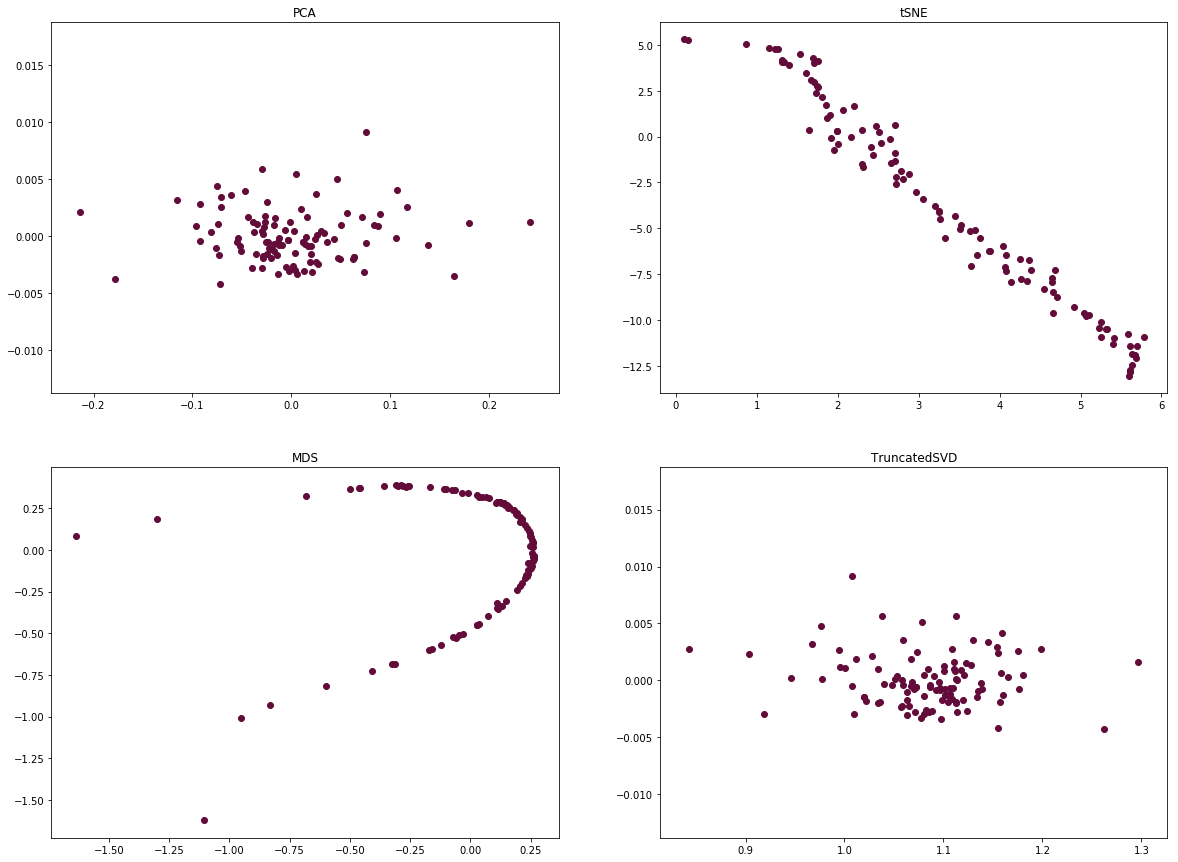

In [888]:
grid_size = (2,2)


plt.figure(figsize=(20,15))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1])
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:, 1])
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1])
plt.title('MDS')

plt.show()

# Clustering

In [690]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN(metric='cityblock', algorithm='auto', min_samples=3, eps=.2) 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation(damping=.6, preference=.5)

# DBSCAN 

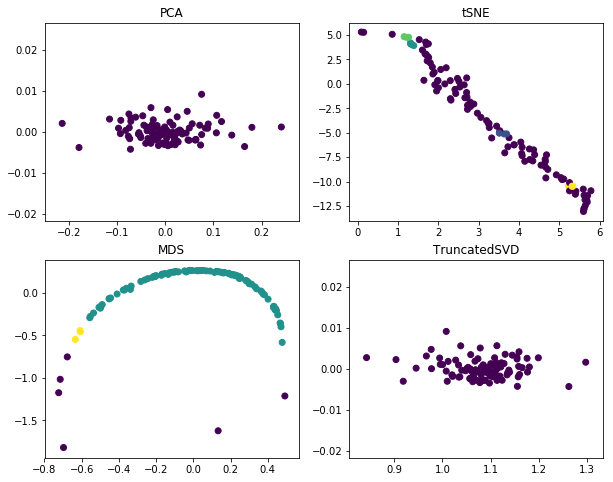

In [726]:
tsvd_dbscan_pred = dbscan.fit_predict(t_svd_data)
tsne_dbscan_pred = dbscan.fit_predict(tsne_data)
dbscan_pca_pred = dbscan.fit_predict(pca_data)
dbscan_mds_pred = dbscan.fit_predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = dbscan_pca_pred)
plt.title('DBSCAN with PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_dbscan_pred)
plt.title('DBSCAN with tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_dbscan_pred)
plt.title('DBSCAN with TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = dbscan_mds_pred)
plt.title('DBSCAN with MDS')

plt.show()

# MeanShift 

In [772]:
tsvd_meanshift = meanshift.fit(t_svd_data)
tsne_meanshift = meanshift.fit(tsne_data)
meanshift_pca = meanshift.fit(pca_data)
meanshift_mds = meanshift.fit(mds_data)

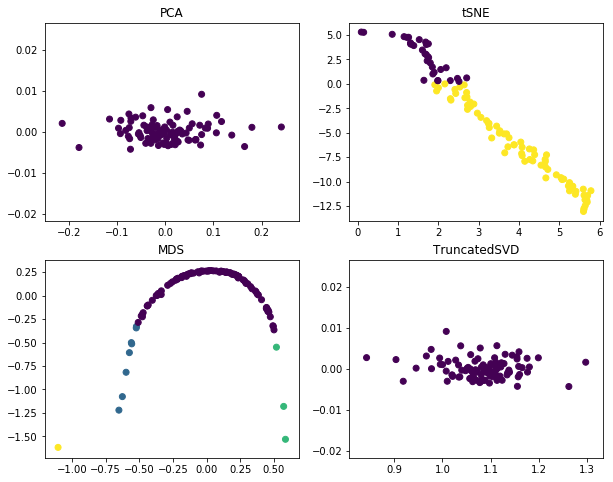

In [773]:
tsvd_meanshift_pred = meanshift.predict(t_svd_data)
tsne_meanshift_pred = meanshift.predict(tsne_data)
meanshift_pca_pred = meanshift.predict(pca_data)
meanshift_mds_pred = meanshift.predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca_pred)
plt.title('MeanShift with PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_meanshift_pred)
plt.title('MeanShift with tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_meanshift_pred)
plt.title('MeanShift with TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = meanshift_mds_pred)
plt.title('MeanShift with MDS')

plt.show()

## Spectral Clustering 

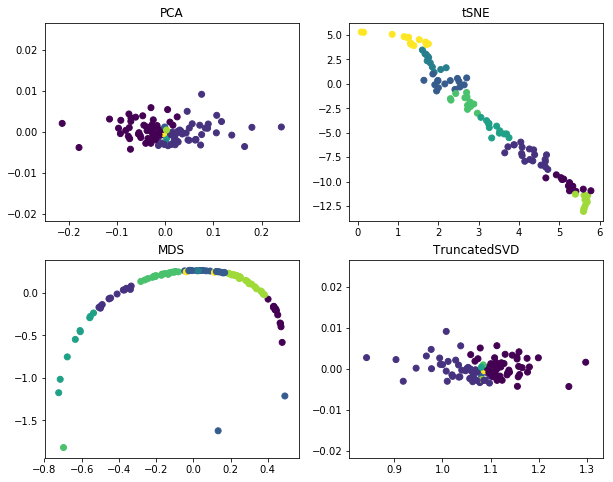

In [729]:
grid_size = (2,2)
tsvd_spectral_pred = spectral.fit_predict(t_svd_data)
tsne_spectral_pred = spectral.fit_predict(tsne_data)
spectral_pca_pred = spectral.fit_predict(pca_data)
spectral_mds_pred = spectral.fit_predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = spectral_pca_pred)
plt.title('Spectral Clustering with PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_spectral_pred)
plt.title('Spectral Clustering with tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral_pred)
plt.title('Spectral Clustering with TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = spectral_mds_pred)
plt.title('Spectral Clustering with MDS')

plt.show()

## Affinity Propagation

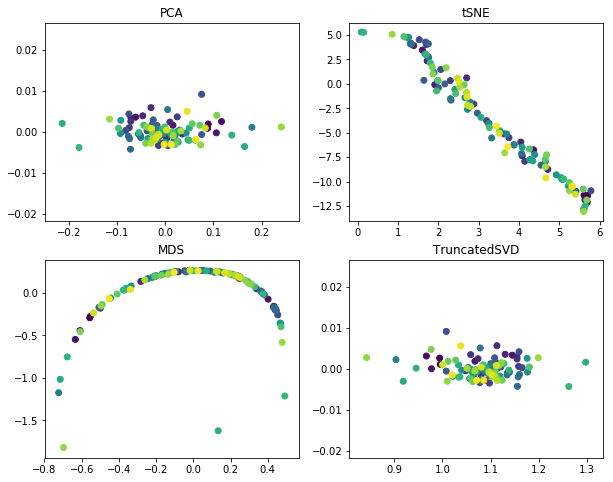

In [730]:
grid_size = (2,2)
tsvd_affinity_pred = affinity.fit_predict(t_svd_data)
tsne_affinity_pred = affinity.fit_predict(tsne_data)
affinity_pca_pred = affinity.fit_predict(pca_data)
affinity_mds_pred = affinity.fit_predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = affinity_pca_pred)
plt.title('Affinity Propagation with PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_affinity_pred)
plt.title('Affinity Propagation with tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_affinity_pred)
plt.title('Affinity Propagation with TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = affinity_mds_pred)
plt.title('Affinity Propagation with MDS')

plt.show()

# Supervised Learning

In [701]:
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

In [702]:
from sklearn.model_selection import GridSearchCV

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    return (grid_classifier, grid_score)


In [703]:
# lets get some confusion matrices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [965]:
# got my params
log_param = {'tol': (.01, .5, 1, 5),
             'C': (.01, .5, 1, 5),
             'solver': ('newton-cg', 'lbfgs', 'sag')}
forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}
svc_param = {'C': (.1, .5, 1, 5),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'degree': (2, 3, 4, 5),
             'gamma': (1, 2, 3)}

# got my estimators
logr = linear_model.LogisticRegression()
gradient = ensemble.GradientBoostingClassifier()
svc = SVC()
forest = ensemble.RandomForestClassifier()

estimators = [logr,
              gradient,
              svc,
              forest]
params = [log_param,
          gradient_param,
          svc_param,
          forest_type_param]

In [992]:
# split training and testing
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25)
sss.get_n_splits(FI_X, FI_y)


for train_index, test_index in sss.split(FI_X, FI_y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [966]:
results = []

for estimator, param in list(zip(estimators, params)):
        best_estimator, grid_score = check_grid(estimator, param, X_train, y_train)
        y_pred = best_estimator.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        results.append((best_estimator, accuracy))
    
print(results)


[(GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tol': (0.01, 0.5, 1, 5), 'C': (0.01, 0.5, 1, 5), 'solver': ('newton-cg', 'lbfgs', 'sag')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 0.1111111111111111), (GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_frac

In [975]:
best_estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [997]:
best_estimator.fit(X_train, y_train)
print(best_estimator.score(X_train, y_train))
print(best_estimator.score(X_test, y_test))

1.0
0.14814814814814814


Confusion matrix, without normalization


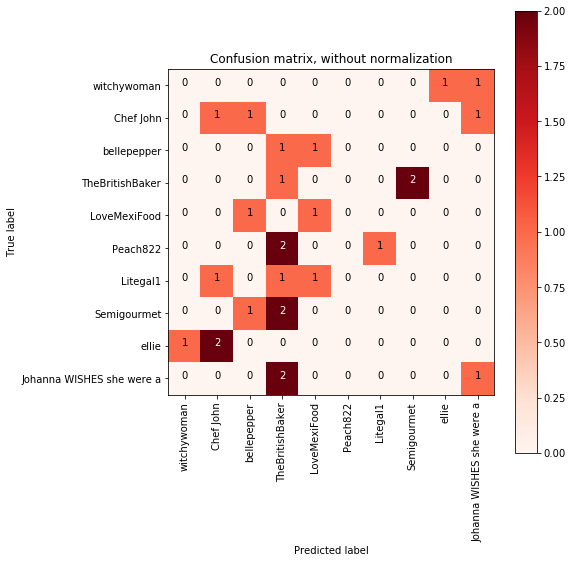

In [998]:
y_pred = best_estimator.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = FI_y.unique()

plt.figure(figsize=(8, 8))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

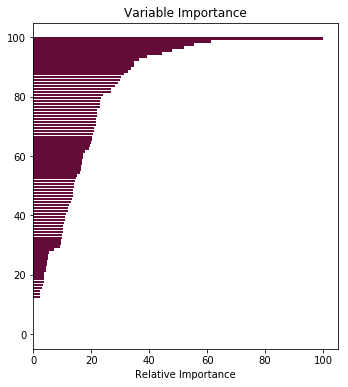

In [952]:
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, best_estimator.classes_[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Do it all over again with test data

In [821]:
# update model
model.train(test, total_examples=26, epochs=5)

2018-05-08 16:15:15,203 : INFO : training model with 3 workers on 409 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2018-05-08 16:15:15,208 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 16:15:15,209 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 16:15:15,215 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 16:15:15,216 : INFO : EPOCH - 1 : training on 1746 raw words (1011 effective words) took 0.0s, 107422 effective words/s
2018-05-08 16:15:15,220 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 16:15:15,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 16:15:15,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 16:15:15,229 : INFO : EPOCH - 2 : training on 1746 raw words (1017 effective words) took 0.0s, 106065 effective words/s
2018-05-08 16:15:15,233 : INFO : worker thre

(5065, 8730)

In [824]:
# grab vocab
X2 = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [896]:
new_word_vectors = model.wv

In [897]:
updated_vectors = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(), 
                                                                                      new_word_vectors,
                                                                                      num_features = 100,
                                                                                      index2word_set = stoplist))


In [898]:
vector_df2 = pd.DataFrame(data=list(updated_vectors))

In [980]:
vector_df2['Author'] = raw_recipe_data['Author']

new_FI_X = vector_df2.loc[:, vector_df2.columns != 'Author']
new_FI_y = vector_df2['Author']

In [981]:
# reduce dimentionality for visualizing
pca = PCA(n_components=2)
pca_data2 = pca.fit_transform(new_FI_X)

tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data2 = tsne.fit_transform(new_FI_X)

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(new_FI_X)
mds_data2 = mds.fit_transform(distances)

t_svd = TruncatedSVD(n_components=2)
t_svd_data2 = t_svd.fit_transform(new_FI_X)

/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


# Clustering whole dataset with test data incorporated

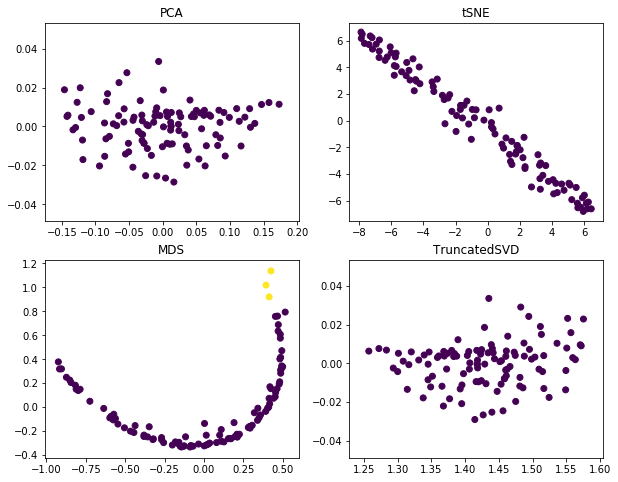

In [1010]:
# cluster DBSCAN
tsvd_dbscan_pred = dbscan.fit_predict(t_svd_data2)
tsne_dbscan_pred = dbscan.fit_predict(tsne_data2)
dbscan_pca_pred = dbscan.fit_predict(pca_data2)
dbscan_mds_pred = dbscan.fit_predict(mds_data2)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], c = dbscan_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], c = tsne_dbscan_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], c = tsvd_dbscan_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], c = dbscan_mds_pred)
plt.title('MDS')

plt.show()

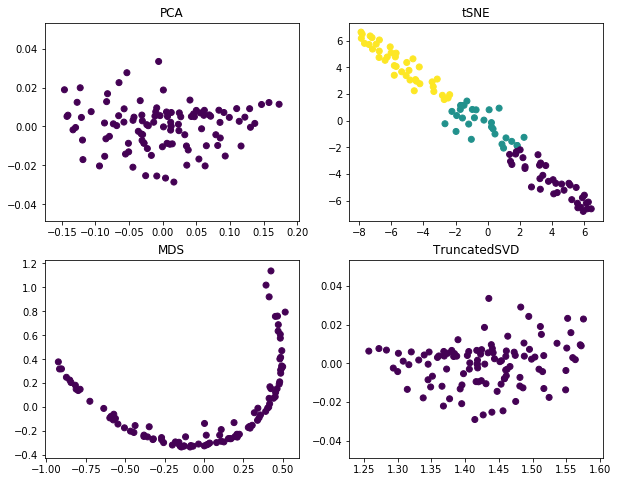

In [1011]:
# Cluster Meanshift
tsvd_meanshift_pred = meanshift.fit_predict(t_svd_data2)
tsne_meanshift_pred = meanshift.fit_predict(tsne_data2)
meanshift_pca_pred = meanshift.fit_predict(pca_data2)
meanshift_mds_pred = meanshift.fit_predict(mds_data2)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], c = meanshift_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], c = tsne_meanshift_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], c = tsvd_meanshift_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], c = meanshift_mds_pred)
plt.title('MDS')

plt.show()

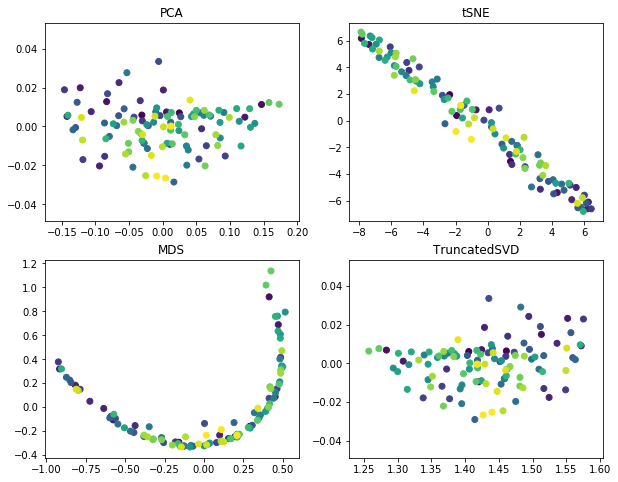

In [1012]:
# plot affinity
grid_size = (2,2)
tsvd_affinity_pred = affinity.fit_predict(t_svd_data2)
tsne_affinity_pred = affinity.fit_predict(tsne_data2)
affinity_pca_pred = affinity.fit_predict(pca_data2)
affinity_mds_pred = affinity.fit_predict(mds_data2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], c = affinity_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], c = tsne_affinity_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], c = tsvd_affinity_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], c = affinity_mds_pred)
plt.title('MDS')

plt.show()

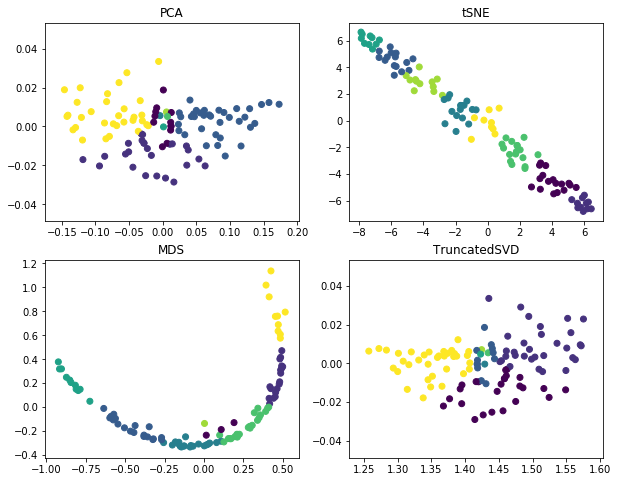

In [1013]:
# cluster Spectral
grid_size = (2,2)
tsvd_spectral_pred = spectral.fit_predict(t_svd_data2)
tsne_spectral_pred = spectral.fit_predict(tsne_data2)
spectral_pca_pred = spectral.fit_predict(pca_data2)
spectral_mds_pred = spectral.fit_predict(mds_data2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], c = spectral_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], c = tsne_spectral_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], c = tsvd_spectral_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], c = spectral_mds_pred)
plt.title('MDS')

plt.show()

In [905]:
# Supervised Learning
sss.get_n_splits(new_FI_X, new_FI_y)

for train_index, test_index in sss.split(new_FI_X, new_FI_y):
    X_train2, X_test2 = X[train_index], X[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]



In [1021]:
best_estimator.fit(X_train2, y_train2)
print(best_estimator.score(X_train2, y_train2))
print(best_estimator.score(X_test2, y_test2))

1.0
0.07407407407407407


Confusion matrix, without normalization


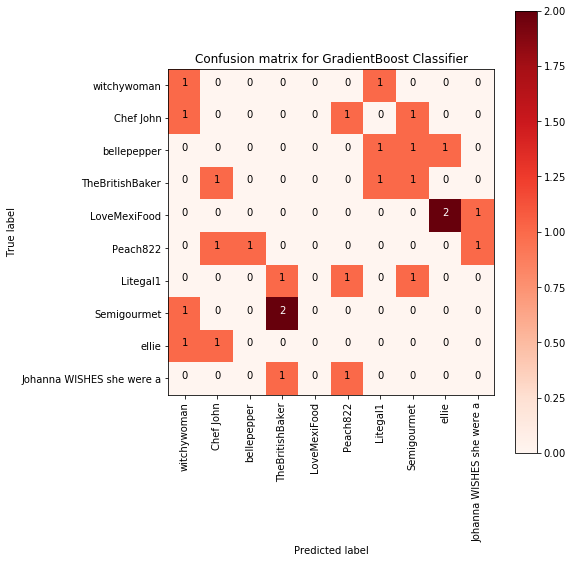

In [1015]:
# confusion matrix for test set
y_pred2 = best_estimator.predict(X_test2)
c_matrix2 = metrics.confusion_matrix(y_test2, y_pred2)

class_names = new_FI_y.unique()

plt.figure(figsize=(8, 8))
plot_confusion_matrix(c_matrix2, classes=class_names,
                      title='Confusion matrix for GradientBoost Classifier')
plt.show()

In [1018]:
#logr = linear_model.LogisticRegression()
#gradient = ensemble.GradientBoostingClassifier()
#svc = SVC()
#forest = ensemble.RandomForestClassifier()


# I just want to see the scores for the other classifiers 
logr.fit(X_train2, y_train2)
print(logr.score(X_train2, y_train2))
print(logr.score(X_test2, y_test2))

svc.fit(X_train2, y_train2)
print(svc.score(X_train2, y_train2))
print(svc.score(X_test2, y_test2))

forest.fit(X_train2, y_train2)
print(forest.score(X_train2, y_train2))
print(forest.score(X_test2, y_test2))



0.15
0.14814814814814814
0.15
0.18518518518518517
1.0
0.18518518518518517


# Clustering Authors with Recipe Instructions

	In this report, I am exploring if I can cluster food authors together given the recipes they submitted to AllRecipe.com. I will be using Gensim along with a few other Natural Language Processing tools I’ve become familiar with.

	I scraped the data with a custom spider I built using python code to collect just the instruction text and the author from my target website, Allrecipe.com. I gathered 10-13 different recipes from 10 different authors and then saved that into a .JSON file, for easy loading into a JupyterNotebook later.  

	The next step was to do some data cleaning. Since I gathered the data myself, I knew there would not be much missing data, but there could still be some. A few of the recipes websites didn’t load properly and so in the file are empty lists where instructions should be and “exception” in place of the author. I used that to my advantage by targeting “exception” and removing those rows from my data. I also combined the different steps into a single long paragraph of instruction, and then lowered the case, translated out the punctuation except for periods, and removed common stop words. I used a custom stop word list because of the specialized nature of my data. 

	Now that the data is cleaned, combined, lowered, and formatted, I set aside 25% of my instructions as a holdout group, and used the other 75% as my training data for the gensim model. The implementation of gensim was quite straightforward and I needed only to present a list of lists that were my instruction sentences. Gensim itself splits up the lists, discovers a vocabulary, and vectorizes each word according to the other words it frequently appears next to and near in my sentences. I then used the vectors Gensim assigned to each word to create a new vector for each of my instructions, combining and averaging the vectors from each word of the instructions. Those vectors I then put into their own DataFrame for easier manipulation. 

	With my new data ready, I was able to experiment with a few different methods of dimensionality reduction. I had Gensim assign 100 dimention neural vectors for each word, so each sentence is represented by a 100 dimentional vector, which is too many to visualize. The methods I chose to reduce those were Principle Component Analysis(PCA), t-Distributed Stochastic Neighbor Embedding(tSNE), Multidimensional Scaling(MDS), and Truncated Singular Value Decomposition(TSVD). Each of these dimensionality reduction algorithms use a slightly different method to reduce the number of dimensions while retaining as much underlying structure, or explained variance as possible. The different methods all reduce down to 2 dimensions, but produce different shapes in the visualizations. tSNE works by converting similarities between points into joint probabilities and then minimizing the change in probabilities between the high-dimensional space and the low-dimensional space. MDS seeks a low dimensional space where the distances respect the distances in the original high-dimensional space. PCA and TSVD are very similar in function in that they both use linear dimensionality reduction algorithms, but with the Truncated version the data is not centered before computing the singular value decomposition so it works well with sparse matrices.

	Now with the dimensions reduced down I was able to plot each set and see what the shape looks like. I put the visualizations together into one plot so I can easily see and compare the shapes from each of the dimensionality reduction techniques. The next step I took is to do some unsupervised clustering. The clustering methods I tested were DBSCAN, MeanShift, Spectral Clustering, and Affinity Propagation. All of the methods produced different cluster groups within the shapes of each of the reduced dimension datasets. Spectral Clustering with the tSNE data produced the closest number of clusters with 8. 

	Following the clustering is supervised learning. I wanted to know if I can predict the Author using the recipe. I used StratifiedKShuffle to create my training and testing data, making sure each label is proportionally represented in my training data. I reserved 25% of my data to validate each models performance. I utilized GridSearchCV to help me find the best estimator. The estimators I tested are LogisticRegression, GradientBoostingClassifier, RandomForestClassifier, and SupportVectorClassifier, also called SVC. The LogisticRegression classifier calculates probabilites to determine class label, while the SVC method impliments a one versus one approach. The RandomForest classifier uses a number of decision trees fit to a subsample of the data and averages the resulting labels to make its predictions. The GradientBoosting classifier uses sequential regression trees in its decision function to aggregate a number of weak learners into a powerful and accurate predicting model. GridSearch is a module in SKLearn that tests a dictionary of hyperparameter settings of a given classifier and returns the parameters that earn the highest accuracy scores. GridSearch returned GradientBoostingClassifier as the best, so I created a new instance of that classifier with the reported hyperparameters. The results were an overfit 1.0 for the training data and .14 for the testing data. I put my data into a confusion matrix, to try and see where the model went wrong. It seems the model greatly preferred the “TheBritishBaker” label, predicting that label 9 times, being correct only once. 

	The next step following the supervised learning is to incorporate the previously reserved 25% of my sentences into the Gensim model and see how they change the behavior of the model. The functionality of the Gensim model was updated a few years ago to include “on the fly” training capabilities which I was grateful for. I added in the new sentences, and re-averaged the vectors for each recipe. 

	When I ran the clustering with the test data incorporated, DBSCAN only found 2 clusters in 1 set of data, the rest all received the same label prediction, suggesting it views those points as noise. MeanShift found 3 clusters in the tSNE data, but the rest received the same label prediction, again, noise. Affinity Propagation predicted far too many clusters, but that is a normal occurrence with that clustering algorithm. The one that returned the best looking clusters, and did not predict the same label for all the rest, was Spectral Clustering, specifically with the tSNE data. The groups are clear through the visualization and tightly packed with little overlap. When testing the estimator with the new test data incorporated it performed less well. It was over fit on the training data again, with a score of 1.0  but the test data score was .03. The confusion matrix reveals virtually all of the predicted labels were incorrect. I checked the other estimators and their scores are little better. The LogisiticRegression and SVC has similar scores of .15 each for training data and .14 and .18 respectively for test data. The RandomForest has a similar score to the GradientBoost, with a 1.0 for training data and .18 for testing data. 

	In conclusion, it appears that Spectral Clustering gives us the most stable clusters across training and testing data. The clusters are clear and tight in each of the visualizations. While the clustering of the data remained stable through the incorportation of the reserved test sentences, the classification portion seemed to perform poorly following it. While GridSearch found that the GradientBoost classifier performed best, after the reintigration of the test sentences, it's performance dropped off. Following that discovery, testing of the other methods revealed the RandomForest to perform similarly to GradientBoost, but the linear based estimators performed better. Both SVC and LogisticRegression returned accuracy scores double that of the GradientBoost and RandomForest, post test sentence reintegration. 